<a href="https://colab.research.google.com/github/HenryLimaa/Jobs/blob/main/DesafioPPAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Instalação das bibliotecas

!pip install earthengine-api
!pip install geemap tensorflow rasterio matplotlib scikit-learn numpy ipywidgets
!pip install segmentation_models_pytorch > /dev/null
!pip install sentinelhub > /dev/null
!pip install geopandas > /dev/null
!pip install shapely > /dev/null
!pip install scikit-image > /dev/null
!pip install --upgrade ipywidgets > /dev/null
!pip install folium > /dev/null
!pip install --upgrade pip > /dev/null
!pip install ipywidgets[widgetsnbextension] > /dev/null
!pip install --upgrade ipywidgets > /dev/null

In [2]:
# @title 1. CONFIGURAÇÃO INICIAL E AUTENTICAÇÃO


# EARTH ENGINE & GEOESPACIAIS
import ee
import geemap
import folium

# DEEP LEARNING & IA
import tensorflow as tf
from tensorflow.keras import layers, models

# PROCESSAMENTO DE IMAGENS E DADOS GEOESPACIAIS
import numpy as np
import cv2
import rasterio
from rasterio.transform import from_origin

# VISUALIZAÇÃO E INTERFACE
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# PRÉ-PROCESSAMENTO & VALIDAÇÃO
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# MANIPULAÇÃO DE ARQUIVOS & DOWNLOAD
import requests
import zipfile
import os
from io import BytesIO

# UTILITÁRIOS E TEMPORAIS
import datetime

# Inicializar Earth Engine
try:
    project_id = input("Digite o ID do seu projeto Earth Engine") # Exemplo: my-earth-engine-project-472319
    ee.Initialize(project=project_id)
except Exception as e:
    print(f"Erro ao inicializar Earth Engine: {e}")
    print("Tentando autenticar...")
    ee.Authenticate()
    project_id = input("Digite o ID do seu projeto Earth Engine após a autenticação: ")
    ee.Initialize(project=project_id)


print("Bibliotecas carregadas e Earth Engine inicializado!")

Digite o ID do seu projeto Earth Enginemy-earth-engine-project-472319
Bibliotecas carregadas e Earth Engine inicializado!


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [3]:
# @title 2. CONFIGURAÇÕES ESPECÍFICAS PARA ALTAMIRA/PA

# Coordenadas do Aeroporto de Altamira/PA
ALTAMIRA_COORDS = [-52.2540, -3.2535]  # [longitude, latitude]
REGIAO_AEROPORTO = ee.Geometry.Point(ALTAMIRA_COORDS).buffer(10000)  # 10km ao redor

In [4]:
# @title 3. FUNÇÕES ESPECÍFICAS PARA DETECÇÃO DE PISTAS

def baixar_imagem_aeroporto_altamira(data_inicio='2023-01-01', data_fim='2023-12-31', nuvens=5):
    """
    Baixa imagem de alta resolução da região do aeroporto de Altamira
    """
    # Filtrar imagens Sentinel-2 com poucas nuvens
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(REGIAO_AEROPORTO) \
        .filterDate(data_inicio, data_fim) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', nuvens)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first()

    # Bandas para detecção de infraestrutura (RGB + NIR)
    imagem_completa = sentinel2.select(['B4', 'B3', 'B2', 'B8'])  # Red, Green, Blue, NIR

    # Aplicar realce para melhor visualização
    imagem_realcada = imagem_completa.visualize(**{
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 3000,
        'gamma': 1.4
    })

    # Download da imagem
    nome_arquivo = f"altamira_aeroporto_{data_inicio}_{data_fim}.tif"
    geemap.ee_export_image(
        imagem_realcada,
        filename=nome_arquivo,
        scale=10,
        region=REGIAO_AEROPORTO.bounds(),
        file_per_band=False
    )

    return nome_arquivo, imagem_completa

def detectar_pistas_por_ndvi(imagem_ee):
    """
    Usa NDVI para detectar áreas pavimentadas (pistas de pouso)
    """
    # Calcular NDVI
    ndvi = imagem_ee.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Áreas pavimentadas geralmente têm NDVI baixo
    areas_pavimentadas = ndvi.lt(0.2)  # Threshold para áreas não-vegetadas

    return areas_pavimentadas, ndvi

def detectar_linhas_retas(imagem_cv):
    """
    Detecta linhas retas características de pistas usando Hough Lines
    """
    # Converter para escala de cinza
    gray = cv2.cvtColor(imagem_cv, cv2.COLOR_RGB2GRAY)

    # Aplicar detecção de bordas
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Detectar linhas com Hough Lines
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=50,
        minLineLength=100,
        maxLineGap=10
    )

    return lines, edges

def criar_modelo_deteccao_pistas():
    """
    Cria modelo CNN para detecção de pistas de pouso
    """
    modelo = models.Sequential([
        # Camada de entrada
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),

        # Camadas intermediárias
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Camadas fully connected
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binária: pista ou não-pista
    ])

    modelo.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return modelo

In [5]:
# @title 4. ANÁLISE ESPECIALIZADA PARA PISTAS DE AEROPORTO

def analisar_pistas_altamira():
    """
    Análise completa das pistas do aeroporto de Altamira
    """
    print("Iniciando análise do Aeroporto de Altamira/PA")
    print("=" * 60)

    # 1. Baixar imagem mais recente
    print("Baixando imagem Sentinel-2...")
    arquivo_imagem, imagem_ee = baixar_imagem_aeroporto_altamira()
    print(f"Imagem baixada: {arquivo_imagem}")

    # 2. Detectar áreas pavimentadas com NDVI
    print("Detectando áreas pavimentadas...")
    areas_pavimentadas, ndvi = detectar_pistas_por_ndvi(imagem_ee)

    # 3. Processar imagem para análise visual
    imagem_cv = cv2.imread(arquivo_imagem)
    imagem_cv = cv2.cvtColor(imagem_cv, cv2.COLOR_BGR2RGB)

    # 4. Detectar linhas retas (pistas)
    print("Detectando linhas retas...")
    linhas, bordas = detectar_linhas_retas(imagem_cv)

    # 5. Calcular métricas
    area_total = REGIAO_AEROPORTO.area().getInfo()  # m²
    print(f" Área total analisada: {area_total:,.0f} m²")

    # 6. Visualizar resultados
    visualizar_resultados_altamira(imagem_cv, linhas, bordas, arquivo_imagem)

    return {
        'arquivo_imagem': arquivo_imagem,
        'areas_pavimentadas': areas_pavimentadas,
        'ndvi': ndvi,
        'linhas_detectadas': linhas,
        'imagem_processada': imagem_cv
    }

def visualizar_resultados_altamira(imagem, linhas, bordas, arquivo_imagem):
    """
    Visualização completa dos resultados
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Imagem original
    axes[0,0].imshow(imagem)
    axes[0,0].set_title('Imagem Original - Aeroporto de Altamira')
    axes[0,0].axis('off')

    # Detecção de bordas
    axes[0,1].imshow(bordas, cmap='gray')
    axes[0,1].set_title('Detecção de Bordas')
    axes[0,1].axis('off')

    # Linhas detectadas
    imagem_linhas = imagem.copy()
    if linhas is not None:
        for line in linhas:
            x1, y1, x2, y2 = line[0]
            cv2.line(imagem_linhas, (x1, y1), (x2, y2), (255, 0, 0), 3)

    axes[1,0].imshow(imagem_linhas)
    axes[1,0].set_title(f'Linhas Detectadas: {len(linhas) if linhas is not None else 0}')
    axes[1,0].axis('off')

    # Histograma de cores para análise de materiais
    #colors = ('r', 'g', 'b')
    #for i, color in enumerate(colors):
        #histogram = cv2.calcHist([imagem], [i], None, [256], [0, 256])
        #axes[1,1].plot(histogram, color=color)
    #axes[1,1].set_title('Histograma de Cores')
    #axes[1,1].set_xlabel('Intensidade')
    #axes[1,1].set_ylabel('Frequência')

    plt.tight_layout()
    plt.savefig('analise_altamira_resultados.png', dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
# @title 5. INTERFACE ESPECIALIZADA PARA AEROPORTOS

def criar_interface_altamira():
    """
    Interface específica para análise do aeroporto de Altamira
    """
    # Widgets específicos para análise aeroportuária
    data_inicio = widgets.DatePicker(
        description='Data Início:',
        value=datetime.date(2023, 1, 1)
    )
    data_fim = widgets.DatePicker(
        description='Data Fim:',
        value=datetime.date(2023, 12, 31)
    )

    limite_nuvens = widgets.IntSlider(
        description='Limite de Nuvens (%):',
        min=0,
        max=20,
        value=5,
        step=1
    )

    botao_analisar = widgets.Button(
        description='Analisar Pistas de Altamira',
        button_style='success',
        icon='search'
    )

    output = widgets.Output()

    def analisar_com_callback(b):
        with output:
            output.clear_output()
            print("Iniciando análise especializada...")
            resultados = analisar_pistas_altamira()
            print("Análise concluída!")

            # Exibir informações específicas
            if resultados['linhas_detectadas'] is not None:
                print(f"Número de linhas detectadas: {len(resultados['linhas_detectadas'])}")

            # Criar mapa interativo
            criar_mapa_altamira_interativo()

    botao_analisar.on_click(analisar_com_callback)

    # Layout organizado
    interface = widgets.VBox([
        widgets.HTML("<h2>Análise de Pistas - Aeroporto de Altamira/PA</h2>"),
        widgets.HBox([data_inicio, data_fim]),
        limite_nuvens,
        botao_analisar,
        output
    ])

    return interface

def criar_mapa_altamira_interativo():
    """
    Mapa interativo focado no aeroporto de Altamira
    """
    # Criar mapa centrado no aeroporto
    mapa = folium.Map(
        location=[-3.2535, -52.2540],
        zoom_start=14,
        tiles='OpenStreetMap'
    )

    # Adicionar marcador do aeroporto
    folium.Marker(
        [-3.2535, -52.2540],
        popup='Aeroporto de Altamira/PA',
        tooltip='Aeroporto Internacional de Altamira',
        icon=folium.Icon(color='red', icon='plane')
    ).add_to(mapa)

    # Adicionar círculo da área de análise
    folium.Circle(
        radius=5000,  # 5km
        location=[-3.2535, -52.2540],
        popup='Área de Análise (5km)',
        color='red',
        fill=False
    ).add_to(mapa)

    # Adicionar camada do Google Satellite
    folium.TileLayer(
        tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr='Google Satellite',
        name='Google Satellite'
    ).add_to(mapa)

    folium.LayerControl().add_to(mapa)

    display(mapa)

    return mapa

In [7]:
# @title 6. RELATÓRIO DE ANÁLISE

def gerar_relatorio_altamira(resultados):
    """
    Gera relatório detalhado da análise
    """
    print("\n" + "="*60)
    print(" RELATÓRIO - AEROPORTO DE ALTAMIRA/PA")
    print("="*60)

    # Informações básicas
    print(f" Localização: Altamira/Pará")
    print(f"  Data da análise: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}")
    print(f" Coordenadas aeroporto: -3.2535°S, -52.2540°W")

    # Métricas detectadas
    if resultados['linhas_detectadas'] is not None:
        print(f" Linhas retas detectadas: {len(resultados['linhas_detectadas'])}")

        # Estimar comprimento médio das linhas (aproximado)
        comprimentos = []
        for linha in resultados['linhas_detectadas']:
            x1, y1, x2, y2 = linha[0]
            comprimento = np.sqrt((x2-x1)**2 + (y2-y1)**2)
            comprimentos.append(comprimento)

        if comprimentos:
            print(f"Comprimento médio das linhas: {np.mean(comprimentos):.1f} pixels")

    print("\n RECOMENDAÇÕES:")
    print("• Verificar alinhamento das pistas detectadas")
    print("• Comparar com dados oficiais do aeroporto")
    print("• Monitorar mudanças na infraestrutura ao longo do tempo")


In [8]:
# @title 7. FUNÇÃO PRINCIPAL ESPECIALIZADA

def main_altamira():
    """
    Função principal especializada para análise do aeroporto de Altamira
    """
    print(" SISTEMA DE ANÁLISE DE PISTAS - AEROPORTO DE ALTAMIRA/PA")
    print("=" * 70)

    # Exibir informações do projeto Earth Engine

    print(" Foco: Aeroporto Internacional de Altamira/PA")
    print(" Objetivo: Detecção e análise de pistas de pouso")

    # Criar interface especializada
    print("\n  Carregando interface...")
    interface = criar_interface_altamira()
    display(interface)

    # Executar análise inicial automática
    print("\n Executando análise inicial...")
    try:
        resultados = analisar_pistas_altamira()
        gerar_relatorio_altamira(resultados)
    except Exception as e:
        print(f"  Análise inicial não pôde ser concluída: {e}")
        print(" Use a interface acima para configurar os parâmetros manualmente")

 SISTEMA DE ANÁLISE DE PISTAS - AEROPORTO DE ALTAMIRA/PA
 Foco: Aeroporto Internacional de Altamira/PA
 Objetivo: Detecção e análise de pistas de pouso

  Carregando interface...



 Executando análise inicial...
Iniciando análise do Aeroporto de Altamira/PA
Baixando imagem Sentinel-2...
Generating URL ...


/usr/local/lib/python3.12/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Please wait ...
Data downloaded to /content/altamira_aeroporto_2023-01-01_2023-12-31.tif
Imagem baixada: altamira_aeroporto_2023-01-01_2023-12-31.tif
Detectando áreas pavimentadas...
Detectando linhas retas...
 Área total analisada: 310,406,007 m²


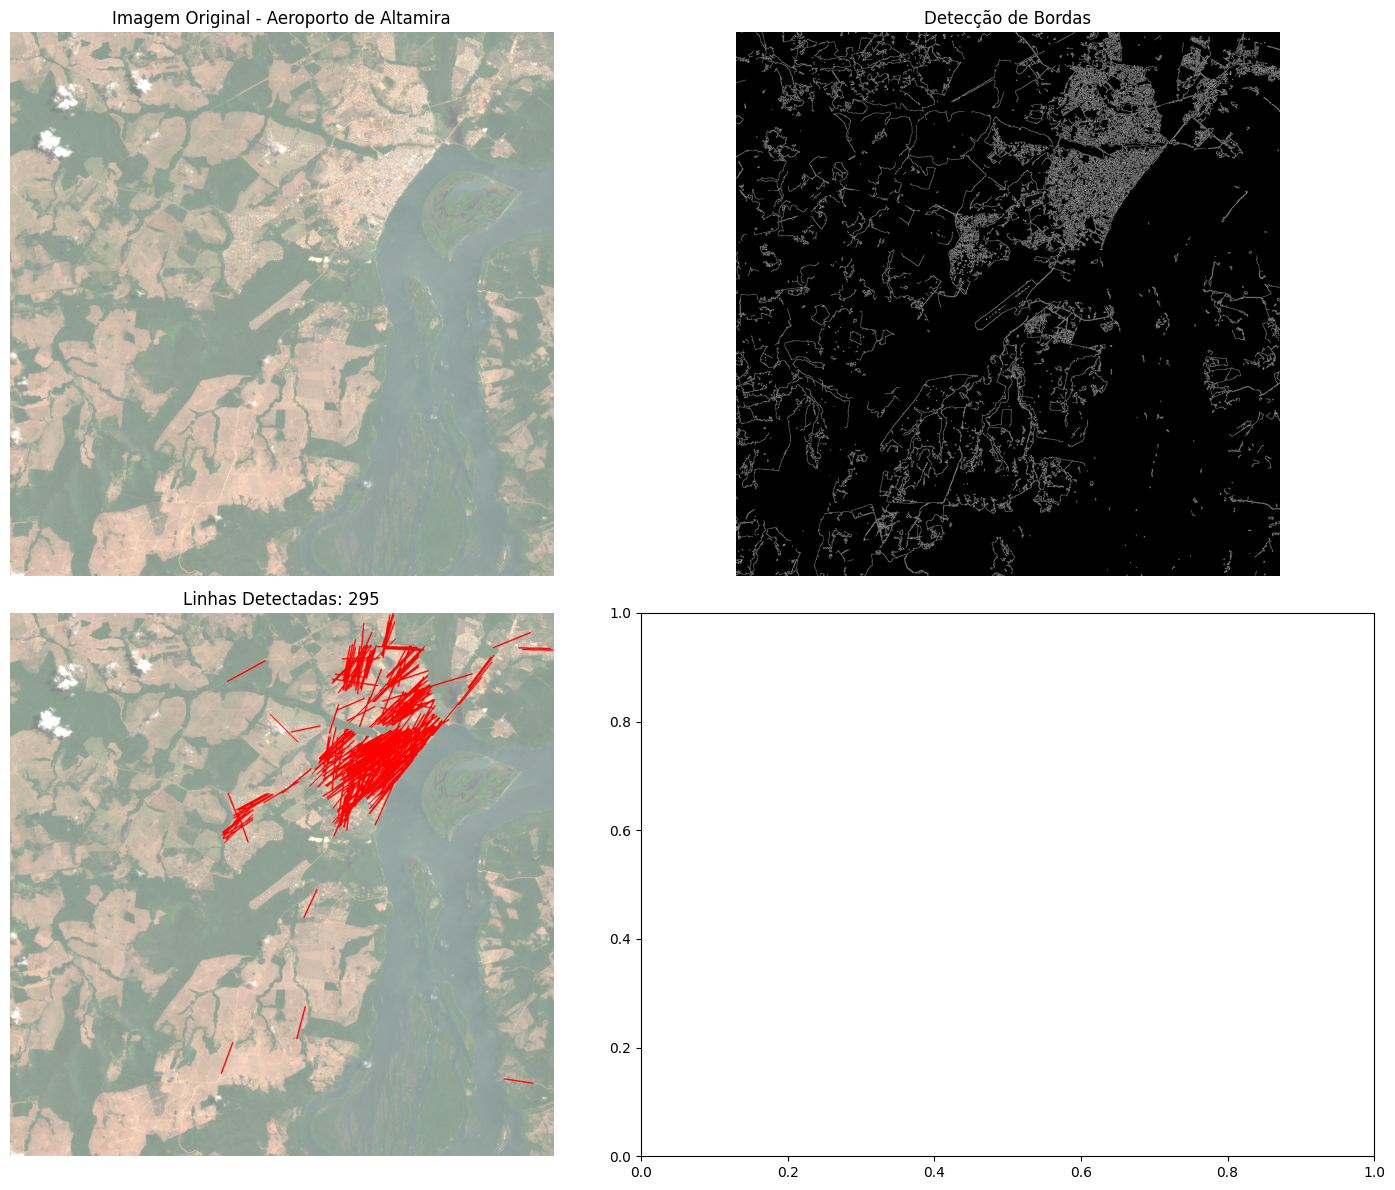


 RELATÓRIO - AEROPORTO DE ALTAMIRA/PA
 Localização: Altamira/Pará
  Data da análise: 2025-09-26 05:29
 Coordenadas aeroporto: -3.2535°S, -52.2540°W
 Linhas retas detectadas: 295
Comprimento médio das linhas: 177.0 pixels

 RECOMENDAÇÕES:
• Verificar alinhamento das pistas detectadas
• Comparar com dados oficiais do aeroporto
• Monitorar mudanças na infraestrutura ao longo do tempo

  FUNÇÕES AVANÇADAS DISPONÍVEIS

    Funções disponíveis:

    1. baixar_imagem_aeroporto_altamira() - Download de imagens atualizadas
    2. detectar_pistas_por_ndvi() - Detecção por índice de vegetação
    3. detectar_linhas_retas() - Detecção de pistas por linhas retas
    4. criar_modelo_deteccao_pistas() - Modelo de IA para classificação
    5. analisar_pistas_altamira() - Análise completa
    6. criar_interface_altamira() - Interface interativa
    


In [9]:
# @title 8. EXECUÇÃO

if __name__ == "__main__":
    # Executar análise especializada
    main_altamira()

    # Exemplo de uso avançado
    print("\n" + "="*70)
    print("  FUNÇÕES AVANÇADAS DISPONÍVEIS")
    print("="*70)

    print("""
    Funções disponíveis:

    1. baixar_imagem_aeroporto_altamira() - Download de imagens atualizadas
    2. detectar_pistas_por_ndvi() - Detecção por índice de vegetação
    3. detectar_linhas_retas() - Detecção de pistas por linhas retas
    4. criar_modelo_deteccao_pistas() - Modelo de IA para classificação
    5. analisar_pistas_altamira() - Análise completa
    6. criar_interface_altamira() - Interface interativa
    """)